In [316]:
import copy
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import imageio
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [116]:
cancer_data = pd.read_csv("../datasets/cancer.csv")
print(cancer_data.shape)
cancer_labels = np.array([1 if l == 'M' else 0 for l in cancer_data['label'].values])
cancer_features = cancer_data.drop(['label'], axis=1).values
cancer_data.head()

(569, 31)


,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [117]:
spam_data = pd.read_csv("../datasets/spam.csv")
print(spam_data.shape)
spam_labels = spam_data['label'].values
spam_features = spam_data.drop(['label'], axis=1).values
spam_data.head()

(4601, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [455]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogitRegression:
    def __init__(self):
        self.w = None
        self.fitted = False

    def fit(self, X, y, lr=0.1, max_iter=100, batch_size=None, X_eval=None, y_eval=None, acc=None, eps=0.001):
        if batch_size is None:
            batch_size = X.shape[0]
        if self.w is None:
            self.w = np.zeros(X.shape[1])
        if X_eval is not None and y_eval is not None:
            best_score = (self.predict(X_eval) == y_eval).mean()
            best_w = np.zeros((X.shape[1], 1))
        for i in range(max_iter):
            for start_ind in range(0, X.shape[0], batch_size):
                X_b, y_b = X[start_ind:start_ind + batch_size], y[start_ind:start_ind + batch_size]
                grad = (y_b / (1 + np.exp(y_b * (X_b @ self.w))) @ X_b) / X_b.shape[0]
                self.w += lr * grad
                if X_eval is not None and y_eval is not None:
                    score = (self.predict(X_eval) == y_eval).mean()
                    if acc is not None:
                        acc.append(score)
                    if score <= best_score - eps:
                        self.fitted = True
                        self.w = best_w
                        return self
                    else:
                        if score > best_score:
                            best_w = copy.deepcopy(self.w)
                            best_score = score
        return self

    def predict_proba(self, X):
        return X @ self.w

    def predict(self, X):
        y = self.predict_proba(X)
        return np.array([1 if y[i] > 0.5 else 0 for i in range(len(y))])

    def coeffs(self):
        return self.w

In [447]:
def log_reg_application(X, y, lr=0.01, batch_size=None, epochs=10, eps=0.001):
    X = MinMaxScaler().fit_transform(X)
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.7)
    model = LogitRegression()
    scores = []
    model.fit(X_tr, y_tr, lr=lr, max_iter=epochs, batch_size=batch_size, X_eval=X_te, y_eval=y_te, acc=scores, eps=eps)
    plt.scatter(range(len(scores)), scores)

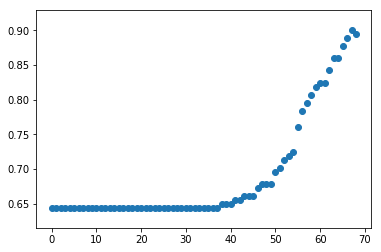

In [456]:
log_reg_application(cancer_features, cancer_labels, lr=0.01, batch_size=30, epochs=100, eps=0.001)

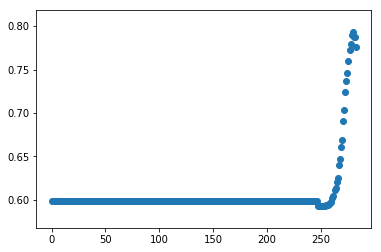

In [457]:
log_reg_application(spam_features, spam_labels, lr=0.01, batch_size=100, epochs=10, eps=0.01)

In [304]:
mnist_data = pd.read_csv("../datasets/mnist.csv")
mnist_labels = mnist_data["label"].values
mnist_features = mnist_data.drop(["label"], axis=1).values.reshape(-1, 1, 28, 28)

In [305]:
mnist_features.shape

(10000, 1, 28, 28)

In [313]:
def read_notMnist():
    data = []
    for root, dirs, files in os.walk("../datasets/notMNIST_small"):
        for file in files:
            if file[-3:] == 'png':
                data.append((root + os.sep + file, root[-1]))
    features = []
    labels = []
    lab_dict = {}
    for pic, lab in data:
        if lab not in lab_dict:
            lab_dict[lab] = len(lab_dict)
        try:
            features.append(imageio.imread(pic).reshape(1, 28, 28))
            labels.append(lab_dict[lab])
        except:
            print("Skip", pic)
    return np.array(features), np.array(labels), lab_dict

notmnist_features, notmnist_labels, notmnist_labels_map = read_notMnist()

Skip ../datasets/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Skip ../datasets/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [220]:
class Net(nn.Module):
    def __init__(self, act):
        super(Net, self).__init__()
        self.act = act
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv3 = nn.Conv2d(8, 8, 3)
        self.fc1 = nn.Linear(8 * 22 * 22, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        x = x.view(-1, 8 * 22 * 22)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

In [302]:
def make_dataloader(X, y):
    tx = torch.stack([torch.Tensor(i) for i in X])
    ty = torch.Tensor(y).long()
    dataset = TensorDataset(tx, ty)
    return DataLoader(dataset, batch_size=4, shuffle=True)

def fit_nn_epoch(net, dataloader, optimizer, criterion):
    running_loss = 0.0
    epoch = 1
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
            
def predict(net, dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    return predicted

def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def fit_images(X, y, activation, epochs=2):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.7)
    trainloader = make_dataloader(X_tr, y_tr)
    testloader = make_dataloader(X_te, y_te)
    
    net = Net(F.relu)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    epochs
    print(accuracy(net, testloader))
    for epoch in range(epochs):
        fit_nn_epoch(net, trainloader, optimizer, criterion)
        print(accuracy(net, testloader))

In [298]:
fit_images(mnist_features, mnist_labels, F.relu)

[2,   200] loss: 1.135
[2,   400] loss: 0.580
[2,   600] loss: 0.473
[2,   800] loss: 0.365
[2,  1000] loss: 0.353
[2,  1200] loss: 0.394
[2,  1400] loss: 0.296
[2,  1600] loss: 0.229
0.928
[2,   200] loss: 0.222
[2,   400] loss: 0.195
[2,   600] loss: 0.207
[2,   800] loss: 0.186
[2,  1000] loss: 0.191
[2,  1200] loss: 0.165
[2,  1400] loss: 0.180
[2,  1600] loss: 0.164
0.9606666666666667


In [300]:
fit_images(mnist_features, mnist_labels, F.sigmoid)

0.08833333333333333
[2,   200] loss: 1.362
[2,   400] loss: 0.738
[2,   600] loss: 0.556
[2,   800] loss: 0.315
[2,  1000] loss: 0.300
[2,  1200] loss: 0.373
[2,  1400] loss: 0.237
[2,  1600] loss: 0.253
0.9433333333333334
[2,   200] loss: 0.176
[2,   400] loss: 0.215
[2,   600] loss: 0.171
[2,   800] loss: 0.208
[2,  1000] loss: 0.178
[2,  1200] loss: 0.183
[2,  1400] loss: 0.178
[2,  1600] loss: 0.177
0.9466666666666667


In [301]:
fit_images(mnist_features, mnist_labels, F.tanh)

0.102
[2,   200] loss: 1.190
[2,   400] loss: 0.629
[2,   600] loss: 0.448
[2,   800] loss: 0.382
[2,  1000] loss: 0.332
[2,  1200] loss: 0.370
[2,  1400] loss: 0.304
[2,  1600] loss: 0.280
0.8393333333333334
[2,   200] loss: 0.226
[2,   400] loss: 0.208
[2,   600] loss: 0.227
[2,   800] loss: 0.164
[2,  1000] loss: 0.172
[2,  1200] loss: 0.194
[2,  1400] loss: 0.156
[2,  1600] loss: 0.179
0.946


In [315]:
fit_images(notmnist_features, notmnist_labels, F.relu)

0.10039159843360626
[2,   200] loss: 1.524
[2,   400] loss: 1.127
[2,   600] loss: 0.876
[2,   800] loss: 0.724
[2,  1000] loss: 0.746
[2,  1200] loss: 0.707
[2,  1400] loss: 0.595
[2,  1600] loss: 0.548
[2,  1800] loss: 0.441
[2,  2000] loss: 0.556
[2,  2200] loss: 0.550
[2,  2400] loss: 0.519
[2,  2600] loss: 0.516
[2,  2800] loss: 0.451
[2,  3000] loss: 0.421
[2,  3200] loss: 0.392
0.8659665361338554
[2,   200] loss: 0.381
[2,   400] loss: 0.358
[2,   600] loss: 0.329
[2,   800] loss: 0.394
[2,  1000] loss: 0.319
[2,  1200] loss: 0.378
[2,  1400] loss: 0.344
[2,  1600] loss: 0.307
[2,  1800] loss: 0.381
[2,  2000] loss: 0.325
[2,  2200] loss: 0.343
[2,  2400] loss: 0.387
[2,  2600] loss: 0.304
[2,  2800] loss: 0.375
[2,  3000] loss: 0.274
[2,  3200] loss: 0.324
0.9047703809184763
